In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
# Define isotope data as a structured dictionary
# Each isotope contains: decay constant (lambda), capture cross section (n_gamma), and production paths
isotopes = {
    'U238': {
        'decay': 0.0,
        'n_gamma': 2.68e-24,
        'prod': []
    },
    'U239': {
        'decay': np.log(2) / (23.5 * 60),
        'n_gamma': 0.0,
        'prod': [('U238', 'n_gamma')]
    },
    'Np239': {
        'decay': np.log(2) / (2.3565 * 24 * 3600),
        'n_gamma': 0.0,
        'prod': [('U239', 'decay')]
    },
    'Pu239': {
        'decay': 0.0,
        'n_gamma': 0.27e-24,
        'prod': [('Np239', 'decay')]
    },
    'Pu240': {
        'decay': 0.0,
        'n_gamma': 0.1e-24,
        'prod': [('Pu239', 'n_gamma')]
    },
    'Am241': {
        'decay': np.log(2) / (432.2 * 365.25 * 24 * 3600),
        'n_gamma': 0.2e-24,
        'prod': [('Pu240', 'n_gamma')]
    },
    'Cm242': {
        'decay': 0.0,
        'n_gamma': 0.0,
        'prod': [('Am241', 'n_gamma')]
    }
}

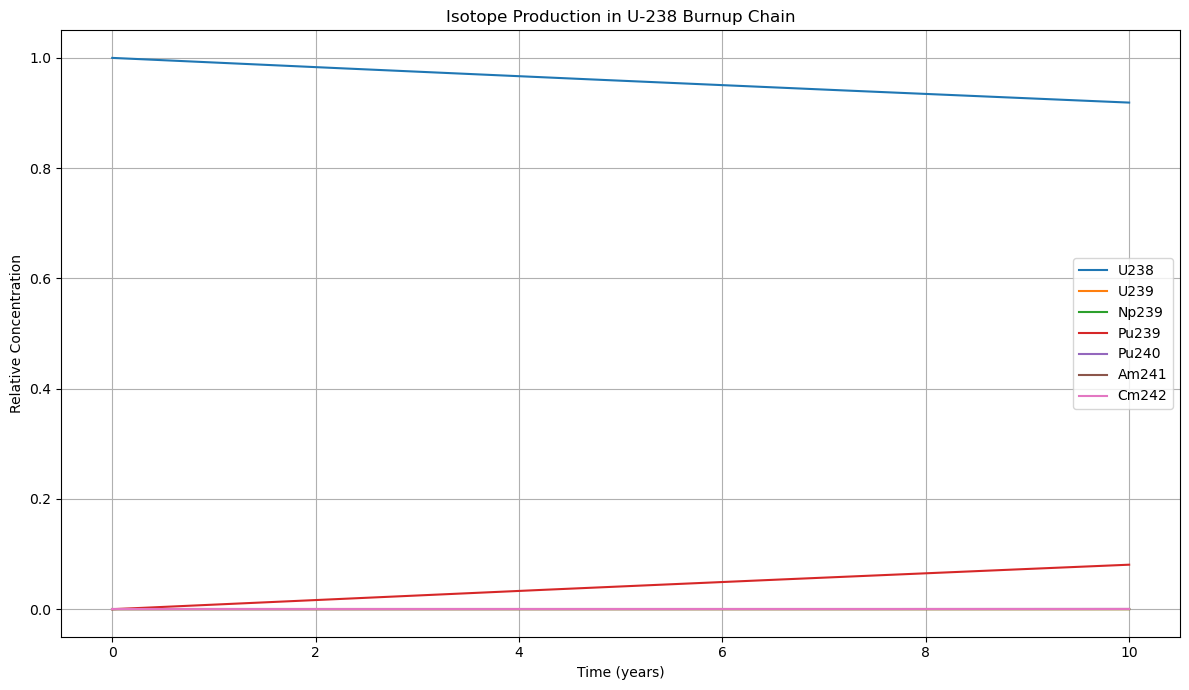

U238: 9.1892e-01
U239: 5.0096e-07
Np239: 7.2344e-05
Pu239: 8.0655e-02
Pu240: 3.5009e-04
Am241: 3.9249e-07
Cm242: 7.2185e-10


In [4]:
phi = 1e14  # neutron flux [n/cm^2/s]
isotope_list = list(isotopes.keys())

# Map isotope to index for the ODE system
index_map = {iso: i for i, iso in enumerate(isotope_list)}
# Define the system of ODEs
def odes(t, y):
    dydt = np.zeros_like(y)
    for iso, props in isotopes.items():
        i = index_map[iso]
        loss = (props['n_gamma'] * phi + props['decay']) * y[i]
        prod = 0.0
        for parent, reaction in props['prod']:
            j = index_map[parent]
            if reaction == 'n_gamma':
                prod += isotopes[parent]['n_gamma'] * phi * y[j]
            elif reaction == 'decay':
                prod += isotopes[parent]['decay'] * y[j]
        dydt[i] = prod - loss
    return dydt

# Initial conditions (only U-238 present initially)
N0 = np.zeros(len(isotope_list))
N0[index_map['U238']] = 1.0

# Time span
T_end = 10 * 365.25 * 24 * 3600  # 10 years in seconds
t_eval = np.linspace(0, T_end, 1000)

# Solve the system
sol = solve_ivp(odes, [0, T_end], N0, t_eval=t_eval, method='BDF')

# Plot the results
plt.figure(figsize=(12, 7))
for i, iso in enumerate(isotope_list):
    plt.plot(sol.t / (365.25 * 24 * 3600), sol.y[i], label=iso)

plt.xlabel('Time (years)')
plt.ylabel('Relative Concentration')
plt.title('Isotope Production in U-238 Burnup Chain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the final concentrations
for i, iso in enumerate(isotope_list):
    print(f"{iso}: {sol.y[i][-1]:.4e}")
